In [1]:
import importlib.util
if importlib.util.find_spec("mtcnn") is None:
    #!pip -q install mtcnn
    !pip -q install git+https://github.com/Amirth24/mtcnn.git

  Preparing metadata (setup.py) ... done


In [2]:
import os
import cv2
import time
import urllib
import hashlib
import numpy as np

from PIL import Image
from mtcnn import MTCNN
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

In [3]:
prototext_path = 'cv2dnn_deploy.prototxt'
caffemodel_path = 'cv2dnn_weights.caffemodel'

if not os.path.isfile(prototext_path):
    !wget -o /dev/null https://raw.githubusercontent.com/ajay-ajani/data/master/face-detect/models/cv2dnn_deploy.prototxt

if not os.path.isfile(caffemodel_path):
    !wget -o /dev/null https://raw.githubusercontent.com/ajay-ajani/data/master/face-detect/models/cv2dnn_weights.caffemodel

mtcnn_classifier = MTCNN()
dnn_classifier = cv2.dnn.readNetFromCaffe(prototext_path, caffemodel_path)
haar_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

(354, 236, 3)


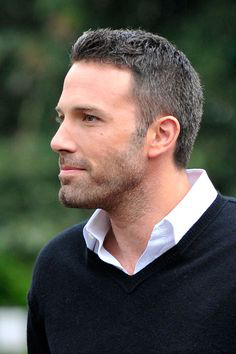

In [18]:
# url = "https://raw.githubusercontent.com/ajay-ajani/data/master/face-detect/images/21.jpg"

# ext = os.path.splitext(url)[1]
# hash = hashlib.sha1(url.encode()).hexdigest()[-16:]
# image = f"{hash}{ext}"

# if not os.path.isfile(image):
#     !wget -O $image -o /dev/null $url

pixels = cv2.imread('ben.jpg')
print(pixels.shape)
image = Image.open('ben.jpg')
display(image)

In [6]:
def extract_faces_mtcnn(pixels, min_size=32, min_confidence=0.5):
    faces = []
    results = mtcnn_classifier.detect_faces(pixels, verbose=0)

    for result in results:
        confidence = result['confidence']
        if confidence < min_confidence: continue

        x1, y1, width, height = result['box']
        if width < min_size or height < min_size: continue

        x2, y2 = x1 + width, y1 + height
        face = pixels[y1:y2, x1:x2]
        faces.append((confidence, face))

    return faces

In [7]:
def extract_faces_haar(pixels, min_size=32, min_confidence=0.5):
    faces = []
    results = haar_classifier.detectMultiScale(pixels)

    for result in results:
        x1, y1, width, height = result
        if width < min_size or height < min_size: continue

        x2, y2 = x1 + width, y1 + height
        face = pixels[y1:y2, x1:x2]
        faces.append((0.5, face))

    return faces

In [8]:
def extract_faces_cv2dnn(pixels, min_size=32, min_confidence=0.5):
    faces = []

    h, w = pixels.shape[:2]
    resized = cv2.resize(pixels, (300, 300))
    blob = cv2.dnn.blobFromImage(resized, 1.0, (300, 300), (104., 117., 123.))

    dnn_classifier.setInput(blob)
    results = dnn_classifier.forward()

    # to draw faces on image
    for i in range(results.shape[2]):
        confidence = results[0, 0, i, 2]
        if confidence < min_confidence: continue

        box = results[0, 0, i, 3:7]
        if np.any(box > 1): continue

        box = box * np.array([w, h, w, h])
        x1, y1, x2, y2 = box.astype("int")
        width, height = (x2 - x1, y2 - y1)
        if width < min_size or height < min_size: continue

        face = pixels[y1:y2, x1:x2]
        faces.append((confidence, face))

    return faces

In [9]:
def rotate(image, angle, scale = 1.0):
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)

    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))

    return rotated

In [10]:
def run_extract_faces(fn, pixels, **kwargs):
    start_time = time.time()
    faces = fn(pixels, **kwargs)
    end_time = time.time()
    print("Time taken:", (end_time - start_time))
    print("Total faces:", len(faces))
    for confidence, face in faces:
      print(face.shape, confidence)
      cv2_imshow(face)

Time taken: 9.604713439941406
Total faces: 1
(133, 105, 3) 0.9982553124427795


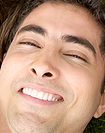

In [11]:
run_extract_faces(extract_faces_mtcnn, pixels, min_confidence=0.2)

--000--
Time taken: 0.05117511749267578
Total faces: 1
(145, 95, 3) 0.9998648


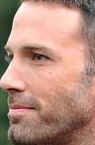

--45--
Time taken: 0.04787254333496094
Total faces: 1
(140, 111, 3) 0.99950635


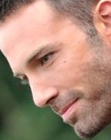

--90--
Time taken: 0.048273324966430664
Total faces: 0
--135--
Time taken: 0.04675626754760742
Total faces: 0
--180--
Time taken: 0.04778695106506348
Total faces: 0
--225--
Time taken: 0.05528616905212402
Total faces: 0
--270--
Time taken: 0.042613983154296875
Total faces: 0
--315--
Time taken: 0.04330849647521973
Total faces: 1
(109, 114, 3) 0.96741253


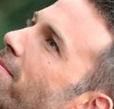

In [20]:
conf = 0.9
print('--000--')
run_extract_faces(extract_faces_cv2dnn, pixels, min_confidence=conf)

for angle in range(45, 360, 45):
    print(f'--{angle}--')
    run_extract_faces(extract_faces_cv2dnn, rotate(pixels, angle), min_confidence=conf)

Time taken: 0.7802009582519531
Total faces: 3
(83, 83, 3) 0.5


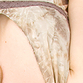

(38, 38, 3) 0.5


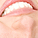

(124, 124, 3) 0.5


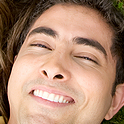

In [13]:
run_extract_faces(extract_faces_haar, pixels)